<a href="https://colab.research.google.com/github/Qaraqororum/IberSiGan/blob/main/IberSiGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten,
                                     RandomFlip,
                                     RandomRotation)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carga y procesado de los datos

Cargamos los datos. Se estructuran en forma de matriz 90x90 con 138 imágenes. Reducimos la resolución de las imágenes para que sea más fácil de entrenar la red neuronal. Además eliminamos algunos signos que empeoran los resultados (en específico uno que es un punto y otro que son 2 puntos, se nota bastante su efecto).

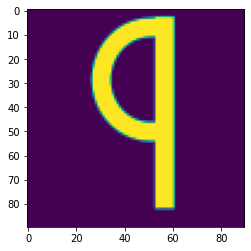

In [ ]:
data = np.load('/content/drive/MyDrive/IberSiGAN/SgnariumProcesado.npy')# cargar de otra fuente los datos si es necesario
plt.imshow(data[:,:,10])

In [ ]:
import pylab as plt

from scipy.interpolate import RegularGridInterpolator

def regrid(data, out_x, out_y):
    m = max(data.shape[0], data.shape[1])
    y = np.linspace(0, 1.0/m, data.shape[0])
    x = np.linspace(0, 1.0/m, data.shape[1])
    interpolating_function = RegularGridInterpolator((y, x), data)

    yv, xv = np.meshgrid(np.linspace(0, 1.0/m, out_y), np.linspace(0, 1.0/m, out_x))

    return interpolating_function((xv, yv))

data_28 = np.zeros([138,28,28])

for i in range(data.shape[2]):
  data_28[i,:,:] = regrid(data[:,:,i],28,28)
  

data_28 = data_28/np.max(data_28)
data_28 = np.delete(data_28,[69,71,77,78,102,103,104,105,106,107,108],axis =0)


# Red neuronal

Empezamos definiendo el generador, la idea es crear una red convolucional profunda con una estructura de capas Convolucional 2D -> Normalization -> ReLU. Utilizamos funciones de activación sigmoides por ser no lineales (funcionan mejor que las lineales al menos en este caso) y tener límites en 0 y 1, no como la tangente hiperbólica, de esta manera salen imágenes más parecidas a las originales y sin ruido de fondo (algo que si pasaba con la tangente). Empezamos con capas convolucionales con muchos canales y pocos píxeles para ir aumentando la resolución hasta el 28*28 de los originales y reduciendo a un solo canal.

Con el modelo discriminador seguimos el mismo patrón pero invirtiendo el crecimiento de las dimensiones, de hecho ahora finalizamos la red con un "aplanado" y una capa densa para tener un coeficiente discriminante.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1],name = "Conv_1"))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same',name = "Conv_2"))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Flatten())
    model.add(Dense(1,name = "Dense_final"))

    return model

Definimos las funciones de pérdida, aquí no tenemos mucho propio, las heos copiado de una red que hacía algo parecido a lo que queríamos pero con cifras escritas a mano. Como cuando tocábamos algo solo iba a peor, está intacto.

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Parámetros de entrenamiento, las épocas y el batch size se han tomado a mano, entrenando con varias configuraciones. Con más épocas muchos de los resultados son ininteligibles y bastantes de los que parecen signos aparecen tal cual en el conjunto original. Con menos épocas aparecen las geometrías básicas de los signos (líneas rectas, diagonales, algún círculo) pero nada más, les falta complejidad.

Con el batch size pasa algo parecido, si pasamos menos imágenes a la vez la red se entrenam muy lentamente y da resultados muy simples, pero si nos pasamos lo que ocurre es que algunos elementos que aparecen más en los signos ganan demasiada importancia y todos los resultados se asemejan demasiado.

In [ ]:

EPOCHS = 500
BATCH_SIZE = 15
BUFFER_SIZE = 100


num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Función para el entrenamiento de la red, no es original, tomada de la red mentada anteriormente y modificada en apenas unas líneas.

In [ ]:

import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      #images = tf.reshape(images, [28,28], name=None)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Función para visualizar los signos generados sobre la marcha. Copiada también.

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
  
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(8,8))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Durante una etapa del desarrollo de la red intentamos aumentar los datos, ya que 136 imágenes parecen pocas, pero los resultados eran mucho peores, este bloque ya no está activo.

In [ ]:
#Bloque de código en desuso, el aumento de datos rotando o flipeando las imágenes daba peores resultados
def prepare(ds, shuffle=True, augment=True):
  # Resize and rescale all datasets.
  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    data_augmentation = tf.keras.Sequential([
      RandomRotation(0.5)
    ])
    
    ds = ds.map(lambda x: (data_augmentation(x, training=True)))

  # Use buffered prefetching on all datasets.
  return ds

# Entrenamiento de la red

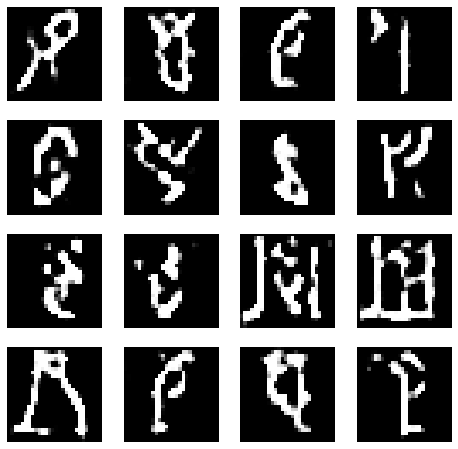

In [ ]:
data_28_ = data_28.reshape(data_28.shape[0], 28, 28, 1).astype('float32')#
data_28_ = tf.data.Dataset.from_tensor_slices(data_28_).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)#prepare(tf.data.Dataset.from_tensor_slices(data_28_)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(data_28_, EPOCHS)